# Basic Network Analysis

`Date: 26/12/2019`

`Author: James Smith`

In this notebook we will do some basic preprocessing and network analysis. Currently we have a standard tablular dataset with independent rows. Thus, in order to do this we will need to manipulate the data in some way. 

## Summary

- [This article](https://www.analyticsvidhya.com/blog/2018/04/introduction-to-graph-theory-network-analysis-python-codes/) is very useful for a quick overview of network analytics. 
- [This article](https://medium.com/@nikkisharma536/knowledge-graph-part-2-modelling-tabular-data-as-graph-cfe1e0ee18fe) goes into more detail on modelling tabular data as a graph.
    > Nodes represent important entities/subjects/objects in our graphs. By having multiple types of node we can take advantage of the connected nature of the graph. For example : if our data set contains data about user and places with some metadata/attributes about both, we will create nodes for User and Place, and connect these by some Relation/edge (eg. User LIVES-IN Place) .

## Identifying Nodes
### Seller (Seller ID)
(if phone numbers are available this would be better - perhaps there are several seller ID's per phone number).

**Node Attributes**
- Seller name
- Number of ads seller has
- Seller location (possibly a separate node)
- Seller registration date
- Seller type

### Ad (Ad ID)

**Node Attributes**
- Ad info

### Car (Car Make + Model)

**Node Attributes**
- Car info

### Location
(county and town concatenated)

**Node Attributes**
- None

Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

table_location = r"C:\Users\User\Documents\ITB Year 2\Text Analytics and Web Content Mining\Assignments\Assignment 3\github\DoneDeal_Analytics\data\ad_info_table.csv"

ad_info_table = pd.read_csv(table_location)

In [2]:
ad_info_table.head()

,Unnamed: 0,ad_age,ad_currency,ad_description,ad_header,ad_id,ad_price,ad_url,car_body_type,car_colour,...,car_year,green_light_verified,seller_county,seller_county_town,seller_id,seller_name,seller_num_ads,seller_phone_number,seller_reg_date,seller_type
0,0,5 hours,EUR,VW CC GT in excellent condition with 67 mile o...,Volkswagen CC GT (price drop),22850112,"13,000",https://www.donedeal.ie/cars-for-sale/volkswag...,Coupe,Brown,...,2015,True,Limerick,NaN,45000,Mike,1,NaN,2010-06-28 14:20:52.312,PRIVATE
1,0,11 days,EUR,2007 mercedes c180 PETROL 1.8 cc.\r\r\n NCT NO...,Mercedes c180 NCT NOV 2020 taxed,23728903,"1,495",https://www.donedeal.ie/cars-for-sale/mercedes...,Saloon,Blue,...,2007,True,Cork,Mallow,31572,Jim S,2,NaN,2009-09-08 22:43:12.027,PRIVATE
2,0,7 mins,EUR,Hello selling my snow white Ford Focus mk3 20...,Ford Focus mk3 2011 1.6 tdci zetec Nct 01.08.21,23749372,"5,599",https://www.donedeal.ie/cars-for-sale/ford-foc...,Saloon,White,...,2011,True,Tipperary,Tipperary Town,3394285,Ford,1,NaN,2019-12-13 21:40:41.166,PRIVATE
3,0,8 mins,EUR,Tax 5/20\r\nNct 14/2/20\r\n1.6 hdi 7 seater\r\...,Peugeot 307 1.6hdi 7 seater tax & nct,23753474,675,https://www.donedeal.ie/cars-for-sale/peugeot-...,Hatchback,Blue,...,2007,False,Kilkenny,NaN,17268,DAVE,8,NaN,2010-10-15 18:39:45.67,PRIVATE
4,0,12 mins,EUR,A very good car drives great new NCT call for ...,Volkswagen,23815100,"10,500",https://www.donedeal.ie/cars-for-sale/volkswag...,MPV,Black,...,2014,False,Dublin,NaN,1305041,Joseph,1,NaN,2014-12-09 17:10:33.103,PRIVATE


## Quick Cleaning

In [3]:
# Only want Private Sellers and those with actual IDs and location
num_rows_original = len(ad_info_table)

data = ad_info_table

data = data[data["seller_type"] == "PRIVATE"]
# data = data.drop(indexNames, inplace = True)

data = data.dropna(subset = ['ad_id','seller_county','seller_id'])

num_rows_clean = len(data)

# print(str(num_rows_original-num_rows_clean), "rows removed")

data = data.sample(frac = 0.05)

In [4]:
len(data)

433

# Representing Pandas Dataframe as Network

**Networkx**

- `from_pandas_dataframe()` - https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.from_pandas_dataframe.html
    - Needs to be fed an edge list representation of a graph
    

## Simple examples

### List attributes as connections to all ads

In [5]:
data.columns

Index(['Unnamed: 0', 'ad_age', 'ad_currency', 'ad_description', 'ad_header',
       'ad_id', 'ad_price', 'ad_url', 'car_body_type', 'car_colour',
       'car_engine', 'car_fuel_type', 'car_make', 'car_mileage', 'car_model',
       'car_nct_expiry', 'car_num_doors', 'car_num_prev_owners',
       'car_reg_country', 'car_road_tax', 'car_transmission', 'car_year',
       'green_light_verified', 'seller_county', 'seller_county_town',
       'seller_id', 'seller_name', 'seller_num_ads', 'seller_phone_number',
       'seller_reg_date', 'seller_type'],
      dtype='object')

In [6]:
import networkx as nx

In [7]:
# # Empty list to store edges
# edges = []

# # Iterrows returns the index and the row info
# for index, ad_info in data.iterrows():
    
#     particular_ad_id = ad_info["ad_id"]
#     particular_ad_connecter = ad_info["seller_id"]
#     # particular_ad_edges = []
    
#     for index, other_ad_info in data.iterrows():
        
#         other_ad_id = other_ad_info["ad_id"]
#         other_ad_connecter = other_ad_info["seller_id"]
        
#         if particular_ad_connecter == other_ad_connecter and particular_ad_id != other_ad_id:
            
#             edge = [(particular_ad_id, other_ad_id, "seller_id", particular_ad_connecter)]
#             edges.extend(edge)
        
# edges    

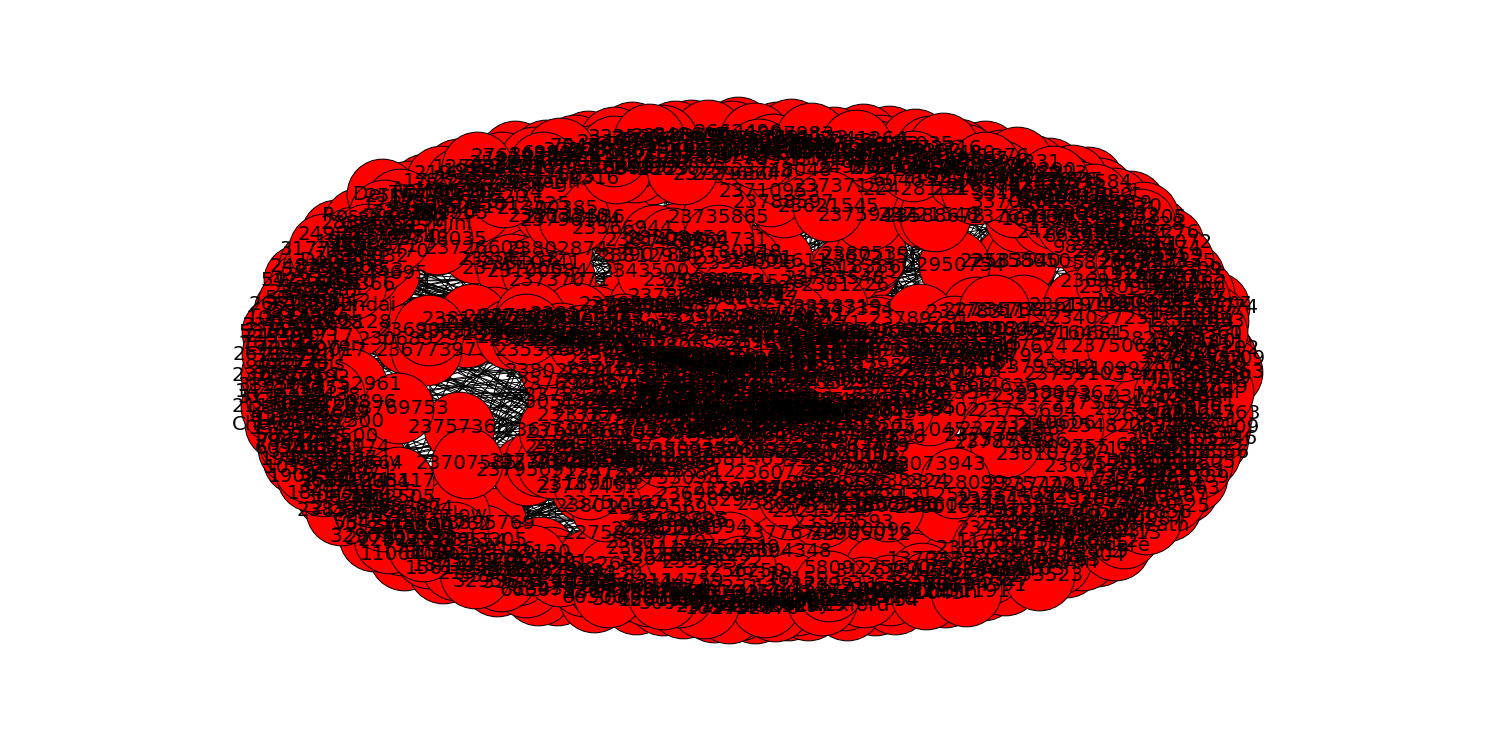

In [8]:
# Taken from https://codepunk.io/building-relationship-graphs-in-python-with-networkx/

# Define what we want to make nodes, car make is debatable
node_types = ["ad_id", "car_make", "seller_county", "seller_id"]

# Get all ads in a list
ad_id_list = data["ad_id"].tolist()

# Initialize list of edges
edges = []

for ad_id in ad_id_list:
    
    # Get a 1 row dataframe for specific ad
    ad = data[data["ad_id"] == ad_id]
    # Transpose to easily loop over columns
    ad_T = ad.transpose()

    for index, info in ad_T.iterrows():
        if index in node_types:
            # Dictionary of edge data - can expand later
            edge_dict = {'ad_title' : ad["ad_header"].values[0],
                         'node_type' : index}
            # Tuple of ad_id and related info
            edges.append((ad_id, info.values[0], edge_dict))

g = nx.DiGraph()
g.add_edges_from(edges)

# Plot
plt.figure(figsize = (20, 10))

nx.draw(g, with_labels = True, node_size = 5000, font_size = 20)  
plt.show() 


In [9]:
# Create a dictionary of list of unique values for node types
# NOTE that the data used here must be all the data 
# that is used for the graph
node_types_list = {node : list(data[node].unique()) for node in node_types}

node_types_list["car_make"][0:5]

['Toyota', 'Nissan', 'Mercedes-Benz', 'Volkswagen', 'Renault']

In [10]:
# How many connections does a given node have coming out of it
g.degree('Skoda')

9

**Function to get unique node values from graph given the type**

In [11]:
# def unique_node_value(g, node_types):
#     """
#     For ease of list comprehensions and visualisation
#     it is useful to have list of all unique nodes in the
#     graph given the type
#     """
     
#     def unique(list): 
#         """
#         Helper function to get unique values for given list
#         """
#         # Insert the list to the set 
#         list_set = set(list) 
#         # Convert the set to the list 
#         return (list(list_set)) 

#     for node_type in node_types:
        
# # Get list of Car Makes from graph
# unique_list = unique([edge[1] for edge in g.edges(data = True) if edge[2]["node_type"] == "car_make"])
# #g.edges(data = True)
# unique_list

## Trying to Create a Nicer Visualisation

Inspired by [this article](http://jonathansoma.com/lede/algorithms-2017/classes/networks/networkx-graphs-from-source-target-dataframe/)

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))

# 1. Create the graph
g = nx.DiGraph()
g.add_edges_from(edges)

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=50)
#layout = nx.spiral_layout(g)

# 3. Draw the parts we want
# - Edges thin and grey
# - Ads small and grey
# - Seller small and green
# - Location sized according to their number of connections
# - Location blue
# - Labels for location and car ONLY
# - Sellers who are highly connected are a highlighted color

# Go through every location name, ask the graph how many
# connections it has. Multiply that by 80 to get the circle size

ads = node_types_list["ad_id"]
sellers = node_types_list["seller_id"]
car_makes = node_types_list["car_make"]
car_makes_size = [g.degree(car_make) * 100 
               for car_make in node_types_list["car_make"]]

counties = node_types_list["seller_county"]
county_size = [g.degree(seller_county) * 100 
               for seller_county in node_types_list["seller_county"]]

nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=counties, 
                       node_size=county_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw Car Makes
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist = car_makes, 
                       node_size = car_makes_size,
                       node_color='#f7fc58')

# Draw ALL ADS
nx.draw_networkx_nodes(g, layout, nodelist = ads, node_color='#bababa', node_size=100)

# Draw ALL SELLERS
nx.draw_networkx_nodes(g, layout, nodelist = sellers, node_color='#5de387', node_size=100)

# Draw POPULAR SELLERS
popular_sellers = [seller for seller in sellers if g.degree(seller) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_sellers, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(counties + car_makes, counties + car_makes))
nx.draw_networkx_labels(g, layout, labels=node_labels)

# 4. Turn off the axis because I know you don't want it
plt.axis('off')

plt.title("Done Deal Network")

# 5. Tell matplotlib to show it
plt.show()

AttributeError: module 'networkx' has no attribute 'spiral_layout'

Things to note:
- It would be better to have the **ads on the outside**
- Seller connectedness proportional to size
- Edge colour different for more important people
- Labels on those who are important sellers
- Choose more appealing colours
- Considering exporting to Gephi
- Consider having as multidirectional graph (**might help with drawing issues**)
- Consider

### Nodes: Ads - Connection: Same Town

In [ ]:
# ad_location_df = ad_info_table[["ad_id", "seller_county"]]

# # Only want complete locations
# ad_location_df = ad_location_df.dropna(subset = ['seller_county'])

# # Define column for location
# # ad_location_df["location"] = ad_location_df['seller_county_town'] + ", " + ad_location_df['seller_county']

# print(str(len(ad_info_table)-len(ad_location_df)), "rows removed")

In [ ]:
# ad_location_df.head()

In [ ]:
# G = nx.from_pandas_edgelist(ad_location_df, 
#                             source = 'seller_county', target = 'ad_id')

# # nx.draw_networkx(G, with_labels = False)
# # Without axes
# nx.draw(G, with_labels = False)

To create a list of edges we need to define the connection
- Two nodes are connected if they have the same *seller_county*

**Algorithm**
1. For one partiular ad, find the *seller_county*
2. For that one partiular ad, loop through every other ad and if it has the same *seller_county*.
3. If so, create a tuple with those two ads

In [ ]:
# edges = []

# for index, ad_info in ad_location_df.iterrows():
#     # ad_info["ad_id"] is the particular add
#     particular_ad_id = ad_info["ad_id"]
#     particular_ad_location = ad_info["seller_county"]
    
#     matches = [(particular_ad_id, other_ad_info["ad_id"]) 
#                for i, other_ad_info in ad_location_df.iterrows() 
#                if other_ad_info["seller_county"] == particular_ad_location
#                   and particular_ad_id != other_ad_info["ad_id"]]
    
#     # Use extend so we have 1-d arrays
#     edges.extend(matches)
    
# df = pd.DataFrame(edges, columns = ['target', 'source'])

In [ ]:
# df.head()

In [ ]:
# G = nx.from_pandas_edgelist(df, source = 'source', target = 'target')

# # nx.draw_networkx(G, with_labels = False)
# # Without axes
# nx.draw(G, with_labels = False)

In [ ]:
# data["ad_id"].tolist()